Importing Computer Vision Libraries

In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


In [4]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

Preparing the data

In [6]:
#training data

train_data = datasets.FashionMNIST(root='data', train= True, transform= ToTensor(), download= True)
test_data = datasets.FashionMNIST(root='data', train= False, transform= ToTensor(), download= True)

In [ ]:
print(f" the length of training data is {len(train_data)}, length of test data  { len(test_data)}")

In [ ]:
#visualize any image randomly
img, label = train_data[2]
img, label

In [ ]:
classnames = train_data.classes
classnames

In [ ]:
#visualize the image

plt.imshow(img.squeeze(), cmap="gray")
plt.title(classnames[label])
plt.axis(False)



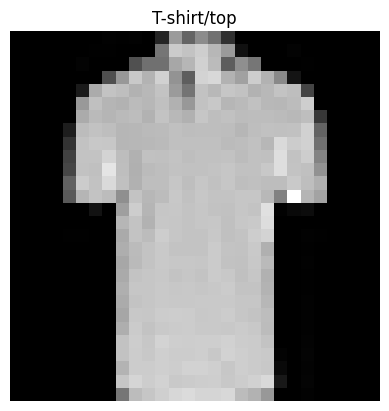

In [25]:
#multiple random images
fig  = plt.Figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows*cols +1):
    #pick image randomly
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.axis(False)
    plt.title(classnames[label])